## Imports

In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2D, BatchNorm, Loss Functions
import torch.optim as optim # All optimization algorithms, SGD, Adam, etc
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformation we can perform on our dataset
from torch.utils.data import DataLoader # Gives easier dataset management and create mini batches
from torch.utils.tensorboard import SummaryWriter # To print to Tensorboard
from torchvision import models
import torchvision

# Utils
import time
import copy
import re
import cv2
from pathlib import Path
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
# Patch for (https://github.com/pytorch/tutorials/issues/762)
# for Tensorboard projector T-SNE, PCA
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Create Fully Connected Network

In [3]:
class CNN(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16*7*7, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

## Set Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Hyperparameters

In [6]:
learning_rate = 1e-3
in_channels = 1
num_classes = 10
batch_size = 4
num_epochs = 1
idx_to_class = ['0','1','2','3','4','5','6','7','8','9']

## Data Process

In [7]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
test_dataset = datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Model and Optimizer

In [9]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes)
model.to(device)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

## Predefined utility functions

### CLI setup

Make sure run Tensorboard in this directory
```bash
$ docker exec -it ml_lab1 bash
$ conda activate tf2
$ cd D/Corona/MaskedFaceDetection/RMFD
$ tensorboard --logdir=runs
```

In [11]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [12]:
def save(model, optimizer, loss, filename):
    save_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item()
        }
    torch.save(save_dict, filename)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    step = 0

    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
        for phase in ['train']:
            if phase == 'train':
                dataset_size = dataset_sizes[0]
                dataloader = train_loader
                model.train()  # Set model to training mode
            else:
                dataset_size = dataset_sizes[1]
                dataloader = test_loader
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                num_corrects = torch.sum(preds == labels.data)
                running_train_acc = float(num_corrects)/float(inputs.shape[0])
                accuracies.append(running_train_acc)
                losses.append(loss.item())
                
                # Tensorboard Running
                ## Data
                img_grid = torchvision.utils.make_grid(inputs)
                writer.add_image('mnist_images', img_grid)
                
                ## Check how the weight changes in specific layer
                writer.add_histogram('fc1', model.fc1.weight)
                
                ## Metrics
                writer.add_scalar('Training Loss', loss.item(), global_step=step)
                writer.add_scalar('Training Accuracy', running_train_acc, global_step=step)
                step += 1
                
                ## Check how the model predicts eg. PCA, T-SNE
                features = inputs.reshape(inputs.shape[0], -1)
                class_labels = [idx_to_class[label] for label in preds]
                if batch_idx == 230:
                    writer.add_embedding(features, metadata=class_labels, label_img=inputs, global_step=batch_idx)

            if phase == 'train' and scheduler != None:
                scheduler.step()

            # Tensorboard Epoch
            writer.add_hparams({'lr': learning_rate, 'bsize': batch_size},
                       {'accuracy': sum(accuracies)/len(accuracies), 
                       'loss': sum(losses)/len(losses)})
    
            epoch_loss = sum(losses)/len(losses)
            epoch_acc = sum(accuracies)/len(accuracies)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # save model
#     save(model, optimizer, loss, 'resnet18-mask-saved.pth')
    
    return model

## Hyperparameter search

In [14]:
# Num of parameters to train
sum(p.numel() for p in model.parameters() if p.requires_grad)

9098

torch.Size([4, 1, 28, 28]) torch.Size([4])
tensor([6, 9, 8, 1])
tensor([[ 0.0518, -0.0459,  0.0853,  0.1427, -0.0157, -0.1281,  0.1050,  0.0546,
          0.0267, -0.0336],
        [ 0.0181, -0.0820,  0.0578,  0.0898,  0.0177, -0.0712,  0.0748,  0.0243,
          0.0282,  0.0502],
        [ 0.0034, -0.0795,  0.0380,  0.1370,  0.0057, -0.1022,  0.0858,  0.0342,
          0.0287,  0.0239],
        [-0.0197, -0.0801,  0.0665,  0.0879,  0.0053, -0.0884,  0.0574,  0.0533,
          0.0164, -0.0013]], device='cuda:0', grad_fn=<AddmmBackward>)


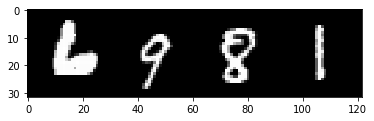

In [15]:
train_iter = iter(train_loader)
samples , labels = train_iter.next()
print(samples.shape, labels.shape)
print(labels[:6])
img_grid = torchvision.utils.make_grid(samples)
show(img_grid)

print(model(samples.to(device)))

In [16]:
batch_sizes = [256]
learning_rates = [0.01, 0.001]
dataset_sizes = [len(train_dataset), len(test_dataset)]

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [17]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        model = CNN(in_channels=in_channels, num_classes=num_classes)
        model.to(device)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
        writer = SummaryWriter(f'runs/MNIST/MiniBatchSize {batch_size} LR {learning_rate}')
        train_model(model, criterion, optimizer, None, num_epochs)

Epoch 0/0
----------
train Loss: 0.2146 Acc: 0.9364

Training complete in 0m 17s
Best val Acc: 0.000000
Epoch 0/0
----------
train Loss: 0.6949 Acc: 0.8166

Training complete in 0m 16s
Best val Acc: 0.000000


## Deploy

In [ ]:
load_checkpoint = torch.load('resnet18-mask-saved.pth')

In [ ]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

resnet.load_state_dict(load_checkpoint['model_state_dict'])
resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0)

optimizer.load_state_dict(load_checkpoint['optimizer_state_dict'])

In [ ]:
# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
resnet_trained = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=2)

## Inference

In [18]:
test_compose = transforms.Compose([transforms.ToPILImage(),
                                   transforms.Resize(224),
                                   transforms.ToTensor(),
                                  ])

In [19]:
def predict(model, numpy_image):
    plt.imshow(numpy_image)
     
    test_image_tensor = test_compose(numpy_image)
    test_image_tensor = test_image_tensor.unsqueeze_(0).to(device)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]])
        

In [21]:
predict(model, test_dataset[47,0])

IndexError: too many indices for tensor of dimension 1